In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score as r2


import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

from datetime import datetime
import os

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
file_path = "./data/wether.csv"

if os.path.exists(file_path):
    df = pd.read_csv(file_path, parse_dates=True, index_col=0)
else:
    url = "https://raw.githubusercontent.com/aweglteo/tokyo_weather_data/main/data.csv"
    df = pd.read_csv(url, parse_dates=True, index_col=0)
    df.to_csv(file_path)
df.info

<bound method DataFrame.info of             cloud  wind  ave_tmp  max_tmp  min_tmp  rain
2018-05-17    9.0   3.7     24.0     28.4     21.4   0.0
2018-05-18    7.8   3.0     23.4     27.1     20.0   0.0
2018-05-19    7.5   3.9     21.5     26.3     15.3   0.0
2018-05-20    4.3   3.5     16.8     22.1     13.1   0.0
2018-05-21   10.0   2.4     20.3     27.2     13.7   0.0
...           ...   ...      ...      ...      ...   ...
2023-05-13   10.0   3.0     16.7     18.1     15.4   5.0
2023-05-14   10.0   3.6     16.9     21.2     14.3   3.0
2023-05-15    9.8   2.0     16.1     18.1     14.6  15.5
2023-05-16    2.8   2.6     19.9     27.5     13.1   0.0
2023-05-17    0.0   2.3     22.8     31.6     15.1   0.0

[1827 rows x 6 columns]>

In [73]:
norm = lambda r: r / np.linalg.norm(r)
data = pd.DataFrame({col: norm(df[col]) for col in ['cloud', 'wind', 'ave_tmp', 'max_tmp', 'min_tmp', 'rain']})
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2018-05-17 to 2023-05-17
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cloud    1827 non-null   float64
 1   wind     1827 non-null   float64
 2   ave_tmp  1827 non-null   float64
 3   max_tmp  1827 non-null   float64
 4   min_tmp  1827 non-null   float64
 5   rain     1827 non-null   float64
dtypes: float64(6)
memory usage: 99.9 KB


In [74]:
df_train, df_test = train_test_split(data, test_size=0.3, shuffle=False)

window_size = 20
n_train = len(df_train) - window_size
n_test = len(df_test) - window_size

train = np.array([df_train.iloc[i:i+window_size].values for i in range(n_train)])
train_labels = np.array([df_train.iloc[i+window_size].values for i in range(n_train)])[:,2]
test = np.array([df_test.iloc[i:i+window_size].values for i in range(n_test)])
test_labels = np.array([df_test.iloc[i+window_size].values for i in range(n_test)])[:,2]

In [75]:
train_data = torch.tensor(train, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.float32)
test_data = torch.tensor(test, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.float32)

In [76]:
class MyLSTM(nn.Module):
    def __init__(self, feature_size, hidden_dim, n_layers):
        super(MyLSTM, self).__init__()
        self.lstm = nn.LSTM(feature_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        

    def forward(self, x):
        h_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = out[:, -1, :]  # 最後の時刻の出力を使用
        out = self.fc(out)
        return out

In [77]:
feature_size = train_data.shape[2]
hidden_dim = 1023
n_layers = 1
net = MyLSTM(feature_size, hidden_dim, n_layers)

criterion = nn.MSELoss()
optimizer = optim.AdamW(net.parameters(), lr=0.001)

summary(net)

Layer (type:depth-idx)                   Param #
MyLSTM                                   --
├─LSTM: 1-1                              4,218,852
├─Linear: 1-2                            1,024
Total params: 4,219,876
Trainable params: 4,219,876
Non-trainable params: 0

In [78]:
net.to(device)
train_data, train_labels = train_data.to(device), train_labels.to(device)

# TensorBoardの設定を行います
log_dir = f"runs/experiment_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
writer = SummaryWriter(log_dir)

In [79]:
epochs = 300
loss_history = []

for epoch in tqdm(range(epochs), desc="Training Epochs"):
    net.train()
    optimizer.zero_grad()
    output = net(train_data)
    loss = criterion(output.squeeze(), train_labels)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    # TensorBoardに損失を記録
    writer.add_scalar('Loss/train', loss.item(), epoch)
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

writer.close()

model_path = 'lstm_model.pth'
torch.save(net.state_dict(), model_path)

Epoch 10/300, Loss: 0.0003364999720361084


Epoch 20/300, Loss: 0.00017138628754764795


Epoch 30/300, Loss: 0.0001009695915854536


Epoch 40/300, Loss: 8.838078792905435e-05


Epoch 50/300, Loss: 8.192125824280083e-05


Epoch 60/300, Loss: 7.719312270637602e-05


Epoch 70/300, Loss: 7.27689330233261e-05


Epoch 80/300, Loss: 6.797016249038279e-05


Epoch 90/300, Loss: 6.219012720976025e-05


Epoch 100/300, Loss: 5.4943364375503734e-05


Epoch 110/300, Loss: 4.520165020949207e-05


Epoch 120/300, Loss: 2.9713253752561286e-05


Epoch 130/300, Loss: 1.2212026376801077e-05


Epoch 140/300, Loss: 1.1538958460732829e-05


Epoch 150/300, Loss: 1.1120675480924547e-05


Epoch 160/300, Loss: 1.0778901923913509e-05


Epoch 170/300, Loss: 1.0481287063157652e-05


Epoch 180/300, Loss: 1.0294161256751977e-05


Epoch 190/300, Loss: 1.0198993550147861e-05


Epoch 200/300, Loss: 1.0136601304111537e-05


Epoch 210/300, Loss: 1.0083925189974252e-05


Epoch 220/300, Loss: 1.0035516424977686e-05


Epoch 230/300, Loss: 9.988926649384666e-06


Epoch 240/300, Loss: 9.944561497832183e-06


Epoch 250/300, Loss: 9.901632438413799e-06


Epoch 260/300, Loss: 9.860415957518853e-06


Epoch 270/300, Loss: 9.820322702580597e-06


Epoch 280/300, Loss: 9.781324479263276e-06


Epoch 290/300, Loss: 9.743548616825137e-06


Training Epochs: 100%|██████████| 300/300 [00:20<00:00, 14.31it/s]

Epoch 300/300, Loss: 9.70665587374242e-06


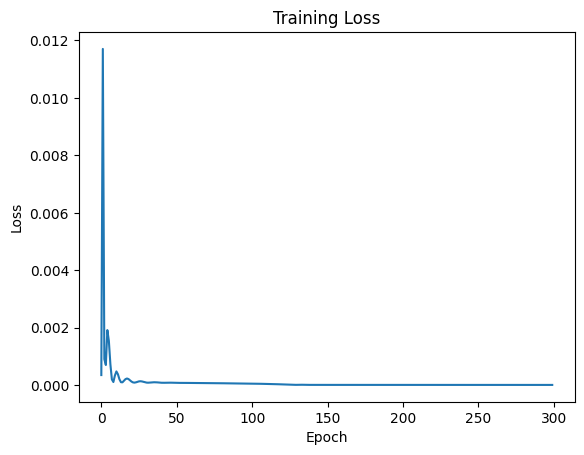

In [80]:
# 損失の履歴を表示する
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [81]:
net = MyLSTM(feature_size, hidden_dim, n_layers)
net.load_state_dict(torch.load(model_path))
net.to(device)
net.eval

# 訓練データに対する予測
predicted_train_plot = []
for k in tqdm(range(n_train), desc="Predicting Training Data"):
    x = torch.tensor(train[k]).reshape(1, window_size, feature_size).to(device).float()
    y = net(x)
    predicted_train_plot.append(y.item())  # 予測値を取得

# テストデータに対する予測
predicted_test_plot = []
for k in tqdm(range(n_test), desc="Predicting Test Data"):
    x = torch.tensor(test[k]).reshape(1, window_size, feature_size).to(device).float()
    y = net(x)
    predicted_test_plot.append(y.item())  # 予測値を取得

Predicting Test Data: 100%|██████████| 529/529 [00:01<00:00, 440.76it/s]


In [82]:
train_mse = mse(train_labels.cpu().numpy(), predicted_train_plot)
train_mae = mae(train_labels.cpu().numpy(), predicted_train_plot)
train_r2 = r2(train_labels.cpu().numpy(), predicted_train_plot)

test_mse = mse(test_labels.cpu().numpy(), predicted_test_plot)
test_mae = mae(test_labels.cpu().numpy(), predicted_test_plot)
test_r2 = r2(test_labels.cpu().numpy(), predicted_test_plot)

print(f'Train MSE: {train_mse}, Train MAE: {train_mae}, Train R2: {train_r2}')
print(f'Test MSE: {test_mse}, Test MAE: {test_mae}, Test R2: {test_r2}')

new_model_path = f'./models/{datetime.now().strftime("%m-%d_%H-%M-%S")}-{test_r2:.3f}-{test_mse:.2e}.pth'
torch.save(net.state_dict(), new_model_path)

os.remove(model_path)

Train MSE: 9.702983788358076e-06, Train MAE: 0.00249854928446676, Train R2: 0.898274302482605
Test MSE: 1.0612642281871877e-05, Test MAE: 0.002565592792790052, Test R2: 0.8943820595741272


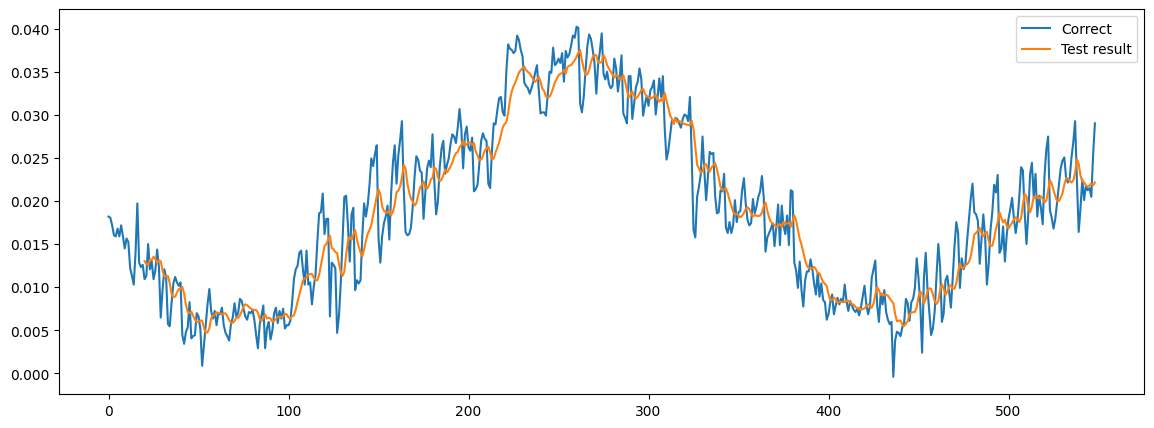

In [83]:
# 可視化
plt.figure(figsize=(14, 5))
plt.plot(range(len(df_test)), df_test.iloc[:, 2].values, label='Correct')
plt.plot(range(window_size, window_size + len(predicted_test_plot)), predicted_test_plot, label='Test result')
plt.legend()
plt.show()